## This notebook is to model Revenue of merchants

### 0 - Begin Spark and read in data

In [1]:
from pyspark.sql import SparkSession, functions as F

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.executor.memory", "3g")
    .config("spark.driver.memory", "3g")
    .getOrCreate()
)

24/10/03 21:22:47 WARN Utils: Your hostname, MacBook.local resolves to a loopback address: 127.0.0.1; using 192.168.0.10 instead (on interface en0)
24/10/03 21:22:47 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/03 21:22:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/10/03 21:22:51 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
revenue_df = spark.read.parquet('../data/curated/revenue.parquet')
revenue_df.show(20, truncate = False)

24/10/03 21:23:02 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


+------------+--------------+-------------------------+--------------------------------------------------+------------+---------+----------------+------------------+----------+------------+-----------------+---------+-------------+--------------------+------------------------+----------------------------------+----------------------------------+-----------+------------------+-----------------------------+--------------------+-----------------------+-------------------------+------------------+
|merchant_abn|order_datetime|merchant_name            |description                                       |revenue_band|take_rate|industry_segment|revenue           |male_count|female_count|undisclosed_count|num_trans|num_postcodes|num_unique_customers|sum_customer_mean_income|average_consumer_fraud_probability|average_merchant_fraud_probability|fraud_count|mean_trans_val    |expected_customer_mean_income|first_order_datetime|days_since_first_record|days_since_first_record_2|cumulative_revenue|
+-

### 1 - Create model for single ABN

#### 1.1 - Set up the dataframes

In [33]:
# Take single ABN as trial
merchant_abn = 46804135891
merchant_df = revenue_df.filter(revenue_df['merchant_abn'] == merchant_abn)

print("Number of entries =", merchant_df.count())
merchant_df.show(20, truncate = False)

Number of entries = 606
+------------+--------------+---------------------------+------------------------------------+------------+---------+----------------+------------------+----------+------------+-----------------+---------+-------------+--------------------+------------------------+----------------------------------+----------------------------------+-----------+------------------+-----------------------------+--------------------+-----------------------+-------------------------+------------------+
|merchant_abn|order_datetime|merchant_name              |description                         |revenue_band|take_rate|industry_segment|revenue           |male_count|female_count|undisclosed_count|num_trans|num_postcodes|num_unique_customers|sum_customer_mean_income|average_consumer_fraud_probability|average_merchant_fraud_probability|fraud_count|mean_trans_val    |expected_customer_mean_income|first_order_datetime|days_since_first_record|days_since_first_record_2|cumulative_revenue|
+-

In [34]:
# Split into training and test df
split_point = int(merchant_df.count() * 0.8)

train_data = merchant_df.limit(split_point)
test_data = merchant_df.subtract(train_data).orderBy('order_datetime')

#### 1.2 - LASSO Linear Regression

In [35]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

# Define predictors
feature_columns = ['days_since_first_record',
                   'days_since_first_record_2',
                   #'num_trans',
                   #'num_postcodes', 
                   #'num_unique_customers',
                   #'average_consumer_fraud_probability', 
                   #'average_merchant_fraud_probability', 
                   #'fraud_count', 
                   #'expected_customer_mean_income',
                   ]

# Assemble the features into a vector
assembler = VectorAssembler(inputCols = feature_columns, outputCol = 'features')

# Linear Regression Model
lasso = LinearRegression(featuresCol = 'features', 
                         labelCol = 'cumulative_revenue',
                         maxIter = 50,
                         elasticNetParam = 1.0, 
                         regParam = 1.0,
                         standardization = True,
                         loss = 'squaredError')

# Create pipeline with assembler and Linear Regression
pipeline = Pipeline(stages = [assembler, lasso])

# Fit to training data
lasso_model = pipeline.fit(train_data)

# Predict on training and test data
train_pred = lasso_model.transform(train_data)
test_pred = lasso_model.transform(test_data)

# Get RMSE
evaluator = RegressionEvaluator(labelCol = 'cumulative_revenue', predictionCol = 'prediction', metricName = 'rmse')

# Train RMSE
print('Training RMSE =', evaluator.evaluate(train_pred))
# Test RMSE
print('Testing RMSE =', evaluator.evaluate(test_pred))


Training RMSE = 71677.45497674658
Testing RMSE = 32673.08206599935


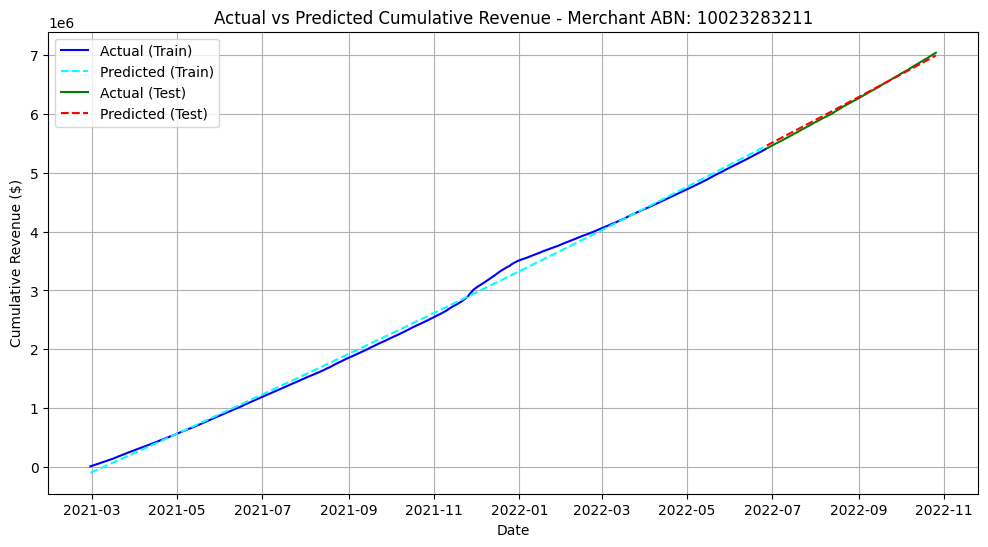

In [37]:
import matplotlib.pyplot as plt

# Convert to Pandas for plotting
train_pd = train_pred.select('order_datetime', 'cumulative_revenue', 'prediction').toPandas()
test_pd = test_pred.select('order_datetime', 'cumulative_revenue', 'prediction').toPandas()

# Plot actual and predicted cumulative_revenue
plt.figure(figsize = (12, 6))

# True training values
plt.plot(train_pd['order_datetime'], train_pd['cumulative_revenue'], label = 'Actual (Train)', color = 'blue')
# Predicted training values
plt.plot(train_pd['order_datetime'], train_pd['prediction'], label = 'Predicted (Train)', color = 'cyan', linestyle = '--')

# True testing values
plt.plot(test_pd['order_datetime'], test_pd['cumulative_revenue'], label = 'Actual (Test)', color = 'green')
# Predicted testing values
plt.plot(test_pd['order_datetime'], test_pd['prediction'], label = 'Predicted (Test)', color = 'red', linestyle = '--')

plt.xlabel('Date')
plt.ylabel('Cumulative Revenue ($)')
plt.title('Actual vs Predicted Cumulative Revenue - Merchant ABN: 10023283211')
plt.legend()
plt.grid(True)
plt.show()


#### 1.3 - Random Forest Regression (For Comparison)

##### 1.3.1 - Train and fit regression

In [7]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

# Define predictors
feature_columns = ['days_since_first_record',
                   'days_since_first_record_2',
                   'num_trans',
                   'num_postcodes', 
                   'num_unique_customers',
                   'average_consumer_fraud_probability', 
                   'average_merchant_fraud_probability', 
                   'fraud_count', 
                   'expected_customer_mean_income',
                   ]

# Assemble the features into a vector
assembler = VectorAssembler(inputCols = feature_columns, outputCol = 'features')
# RFR
rf = RandomForestRegressor(numTrees = 100, maxDepth = 5, featuresCol = 'features', labelCol = 'revenue')
# Create pipeline with assembler and RF
pipeline = Pipeline(stages = [assembler, rf])

# Fit to training data
rf_model = pipeline.fit(train_data)

# Predict on training and test data
train_pred = rf_model.transform(train_data)
test_pred = rf_model.transform(test_data)

# Get RMSE
evaluator = RegressionEvaluator(labelCol = 'revenue', predictionCol = 'prediction', metricName = 'rmse')
# Train RMSE
print('Training RMSE =', evaluator.evaluate(train_pred))
# Test RMSE
print('Testing RMSE =', evaluator.evaluate(test_pred))

Training RMSE = 273.8452968525768
Testing RMSE = 327.01291888975993


##### 1.3.2 - Plot actual vs. predicted

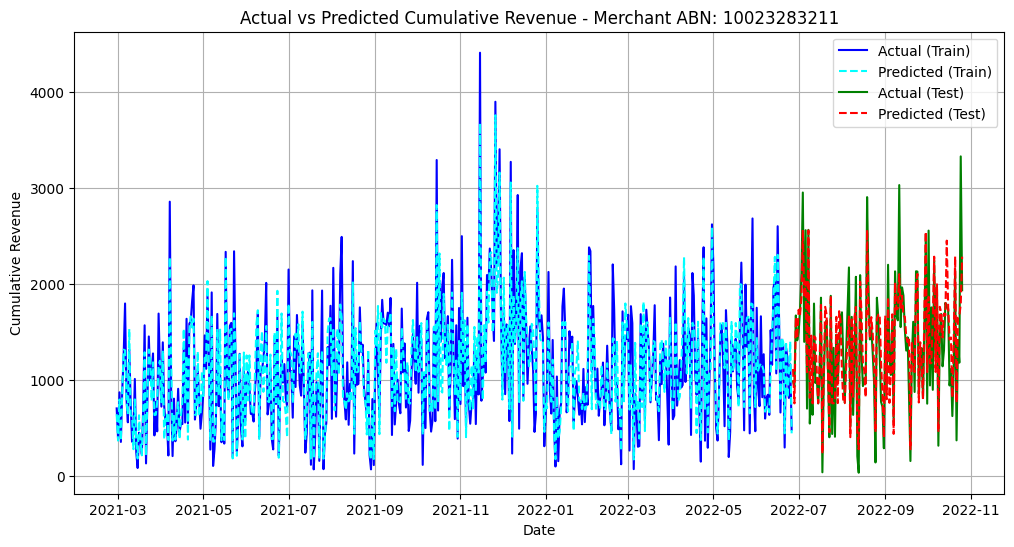

In [8]:
import matplotlib.pyplot as plt

# Convert to Pandas for plotting
train_pd = train_pred.select('order_datetime', 'revenue', 'prediction').toPandas()
test_pd = test_pred.select('order_datetime', 'revenue', 'prediction').toPandas()

# Plot actual and predicted cumulative_revenue
plt.figure(figsize = (12, 6))

# True training values
plt.plot(train_pd['order_datetime'], train_pd['revenue'], label = 'Actual (Train)', color = 'blue')
# Predicted training values
plt.plot(train_pd['order_datetime'], train_pd['prediction'], label = 'Predicted (Train)', color = 'cyan', linestyle = '--')

# True testing values
plt.plot(test_pd['order_datetime'], test_pd['revenue'], label = 'Actual (Test)', color = 'green')
# Predicted testing values
plt.plot(test_pd['order_datetime'], test_pd['prediction'], label = 'Predicted (Test)', color = 'red', linestyle = '--')

plt.xlabel('Date')
plt.ylabel('Cumulative Revenue')
plt.title('Actual vs Predicted Cumulative Revenue - Merchant ABN: 10023283211')
plt.legend()
plt.grid(True)
plt.show()


#### 1.4 - SARIMAX

##### 1.4.1 - Prepare the dataframe

In [39]:
import pandas as pd

# Make predictions
train_pred = lasso_model.transform(train_data)
test_pred = lasso_model.transform(test_data)

# Select relevant columns and convert to Pandas DataFrame
train_pred_pd = train_pred.select('cumulative_revenue', 'prediction', 'order_datetime').toPandas()
test_pred_pd = test_pred.select('cumulative_revenue', 'prediction', 'order_datetime').toPandas()

# Combine predictions into a single DataFrame
merchant_pd = pd.concat([train_pred_pd, test_pred_pd])

merchant_pd['order_datetime'] = pd.to_datetime(merchant_pd['order_datetime'])
merchant_pd.set_index('order_datetime', inplace = True)

# Reindex to fill missing dates
full_range = pd.date_range(start = merchant_pd.index.min(), end = merchant_pd.index.max(), freq = 'D')
# Fill missing values as 0 -> no transactions on day
merchant_pd = merchant_pd.reindex(full_range).fillna(0)  

##### 1.4.2 - Train and fit the model, then plot the forcasted revenue

{'fopt': np.float64(7.5927879788665), 'gopt': array([-6.44303277e-05,  1.35349509e-06, -8.23494162e-05,  2.57571742e-09,
        1.92734718e-07]), 'fcalls': 348, 'warnflag': 0, 'converged': True, 'iterations': 51}


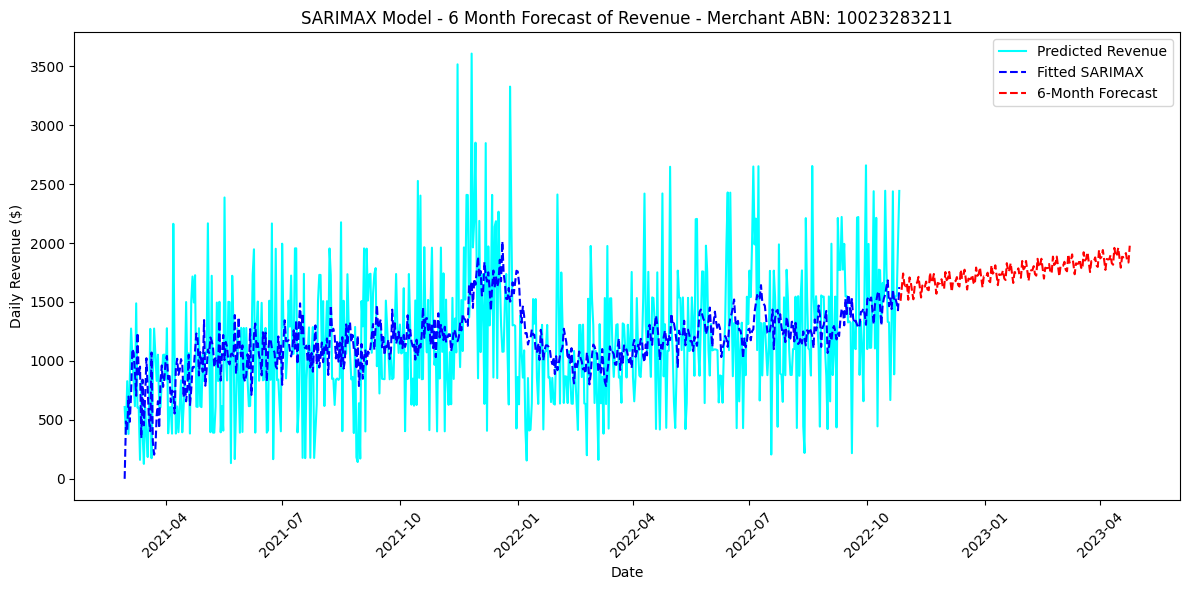

In [32]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

time_series_data = merchant_pd['prediction']

# Fit seasonal autoregression (SARIMAX) model to predicted revenue
model = SARIMAX(time_series_data, order = (1, 1, 1), seasonal_order = (1, 1, 1, 12), freq = "D")
fitted_model = model.fit(maxiter = 500, disp = False)
print(fitted_model.mle_retvals)

# Get in-sample predictions
in_sample_predictions = fitted_model.fittedvalues

# Forecast 180 days
forecast_steps = 180
forecast = fitted_model.forecast(steps = forecast_steps)

# Create forecast index for 180 days
last_date = time_series_data.index[-1]
forecast_index = pd.date_range(start = last_date + pd.DateOffset(days = 1), periods = forecast_steps, freq = 'D')
forecast_series = pd.Series(forecast, index = forecast_index)

# Plot the results
plt.figure(figsize = (12, 6))
plt.plot(time_series_data.index, time_series_data, label = 'Predicted Revenue', color = 'cyan')

plt.plot(in_sample_predictions.index, in_sample_predictions, label = 'Fitted SARIMAX', color = 'blue', linestyle = '--')
plt.plot(forecast_series.index, forecast_series, label = '6-Month Forecast', color = 'red', linestyle = '--')

plt.title('SARIMAX Model - 6 Month Forecast of Revenue - Merchant ABN: 10023283211')
plt.xlabel('Date')
plt.ylabel('Daily Revenue ($)')
plt.legend()

plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

{'fopt': np.float64(8.580911077022451), 'gopt': array([-1.49746882e-07,  1.13404752e-04, -5.25068344e-04,  5.48006085e-07,
        3.82271993e-07]), 'fcalls': 348, 'warnflag': 0, 'converged': True, 'iterations': 47}


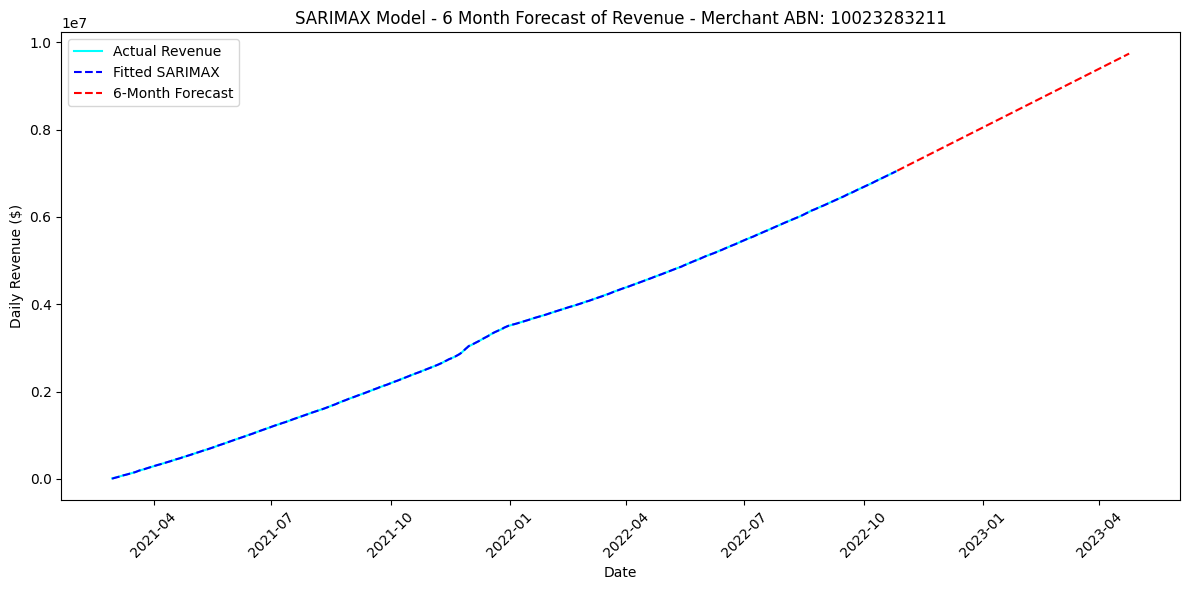

In [40]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

time_series_data = merchant_pd['cumulative_revenue']

# Fit seasonal autoregression (SARIMAX) model to cumulative revenue
model = SARIMAX(time_series_data, order = (1, 1, 1), seasonal_order = (1, 1, 1, 7), freq = "D")
fitted_model = model.fit(maxiter = 500, disp = False)
print(fitted_model.mle_retvals) # Check whether fitted model converged to a solution

# Get in-sample predictions
in_sample_predictions = fitted_model.fittedvalues

# Forecast 180 days
forecast_steps = 180
forecast = fitted_model.forecast(steps = forecast_steps)

# Create forecast index for 180 days
last_date = time_series_data.index[-1]
forecast_index = pd.date_range(start = last_date + pd.DateOffset(days = 1), periods = forecast_steps, freq = 'D')
forecast_series = pd.Series(forecast, index = forecast_index)

# Plot the results
plt.figure(figsize = (12, 6))
plt.plot(time_series_data.index, time_series_data, label = 'Actual Revenue', color = 'cyan')

plt.plot(in_sample_predictions.index, in_sample_predictions, label = 'Fitted SARIMAX', color = 'blue', linestyle = '--')
plt.plot(forecast_series.index, forecast_series, label = '6-Month Forecast', color = 'red', linestyle = '--')

plt.title('SARIMAX Model - 6 Month Forecast of Revenue - Merchant ABN: 10023283211')
plt.xlabel('Date')
plt.ylabel('Daily Revenue ($)')
plt.legend()

plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

#### 1.5 - SARIMAX for Cumulative Revenue

In [41]:
# Take single ABN for trial
merchant_abn = 46804135891
merchant_df = revenue_df.filter(revenue_df['merchant_abn'] == merchant_abn)

print("Number of entries =", merchant_df.count())
merchant_df.show(20, truncate = False)

Number of entries = 606
+------------+--------------+---------------------------+------------------------------------+------------+---------+----------------+------------------+----------+------------+-----------------+---------+-------------+--------------------+------------------------+----------------------------------+----------------------------------+-----------+------------------+-----------------------------+--------------------+-----------------------+-------------------------+------------------+
|merchant_abn|order_datetime|merchant_name              |description                         |revenue_band|take_rate|industry_segment|revenue           |male_count|female_count|undisclosed_count|num_trans|num_postcodes|num_unique_customers|sum_customer_mean_income|average_consumer_fraud_probability|average_merchant_fraud_probability|fraud_count|mean_trans_val    |expected_customer_mean_income|first_order_datetime|days_since_first_record|days_since_first_record_2|cumulative_revenue|
+-

In [42]:
# Split into training and test df
split_point = int(merchant_df.count() * 0.8)

train_data = merchant_df.limit(split_point)
test_data = merchant_df.subtract(train_data).orderBy('order_datetime')

In [43]:
import pandas as pd
train_pd = train_data.select('order_datetime', 'cumulative_revenue').toPandas()
test_pd = test_data.select('order_datetime', 'cumulative_revenue').toPandas()

# Convert 'order_datetime' to date time data type
train_pd['order_datetime'] = pd.to_datetime(train_pd['order_datetime'])
train_pd.set_index('order_datetime', inplace = True)
test_pd['order_datetime'] = pd.to_datetime(test_pd['order_datetime'])
test_pd.set_index('order_datetime', inplace = True)

# Missing day -> 0 transactions on date
full_range = pd.date_range(start = train_pd.index.min(), end = train_pd.index.max(), freq = 'D')
train_pd = train_pd.reindex(full_range).fillna(0)
full_range = pd.date_range(start = test_pd.index.min(), end = test_pd.index.max(), freq = 'D')
test_pd = test_pd.reindex(full_range).fillna(0)

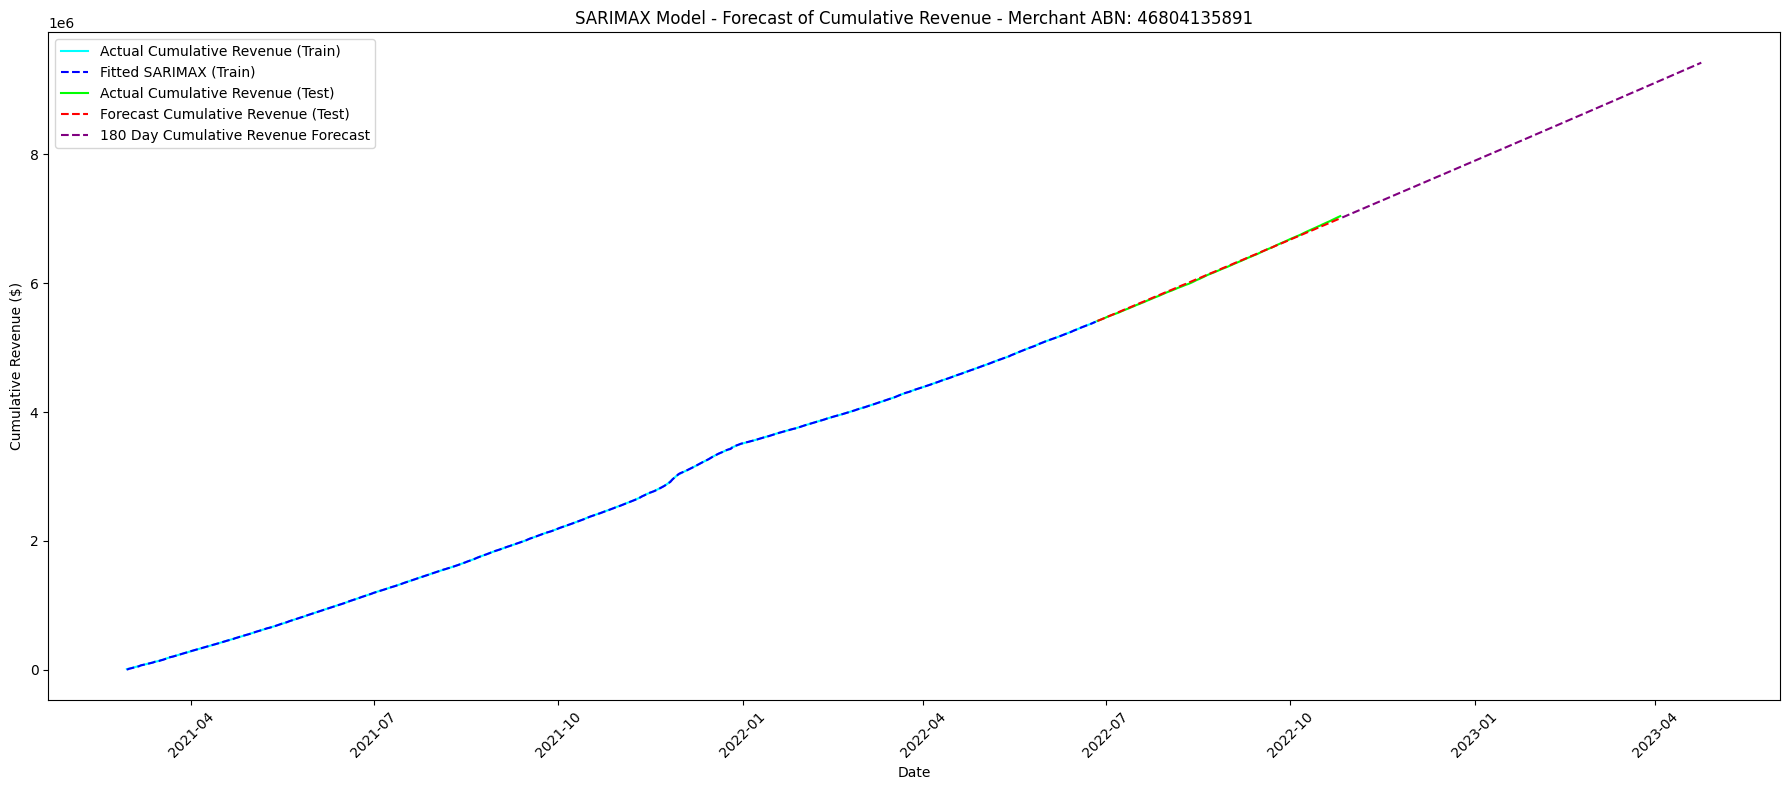

Training RMSE = 1602.976473045607
Testing RMSE = 12155.819389397564


In [50]:
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

time_series_data = train_pd['cumulative_revenue']

model = SARIMAX(time_series_data, order = (1, 1, 1), seasonal_order = (1, 1, 1, 7), freq = 'D')
fitted_model = model.fit(maxiter = 500, disp = False)

# Get in-sample predictions for RMSE calculation
in_sample_predictions = fitted_model.fittedvalues

# Forecasting on test data
forecast_steps = len(test_pd)
forecast_test = fitted_model.forecast(steps = forecast_steps)

# Forecasting for the next 180 days after the test set
forecast_180_days = fitted_model.forecast(steps = len(test_pd) + 180)

# Create forecast index for 180 days
last_date = test_pd.index[-1]
forecast_index_180_days = pd.date_range(start = last_date + pd.DateOffset(days = 1), periods = len(test_pd) + 180, freq = 'D')
forecast_series_180_days = pd.Series(forecast_180_days, index = forecast_index_180_days)

# RMSE calculations
rmse_train = np.sqrt(mean_squared_error(time_series_data, in_sample_predictions))
rmse_test = np.sqrt(mean_squared_error(test_pd['cumulative_revenue'], forecast_test))

# Plotting
plt.figure(figsize = (18, 8))
plt.plot(time_series_data.index, time_series_data, label = 'Actual Cumulative Revenue (Train)', color = 'cyan')
plt.plot(in_sample_predictions.index, in_sample_predictions, label = 'Fitted SARIMAX (Train)', color = 'blue', linestyle = '--')
plt.plot(test_pd.index, test_pd['cumulative_revenue'], label = 'Actual Cumulative Revenue (Test)', color = 'lime')
plt.plot(test_pd.index, forecast_test, label = 'Forecast Cumulative Revenue (Test)', color = 'red', linestyle = '--')
plt.plot(forecast_series_180_days.index, forecast_series_180_days, label = '180 Day Cumulative Revenue Forecast', color = 'purple', linestyle = '--')

# Title and axis labels
plt.title('SARIMAX Model - Forecast of Cumulative Revenue - Merchant ABN: 46804135891')
plt.xlabel('Date')
plt.ylabel('Cumulative Revenue ($)')
plt.legend()

plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

# Print RMSE values
print("Training RMSE =", rmse_train)
print("Testing RMSE =", rmse_test)

From the analysis above, the best way to model merchant revenue is by using a SARIMAX auto-regression model to model cumulative revenue. </br>
The feature found to be significantly impactful for predicting cumulative revenue was past cumulative revenue.

### 2 - Loop over all merchants

First date: 2021-02-28 <br>
Last date: 2022-10-26 <br>
606 days <br>
485 days -> 80% <br>
<br>
Split date: 2022-06-28 <br>
Forecast to: 2023-05-01


#### 2.1 - Functions for looping over merchants

In [3]:
# This function returns the data from a single merchant
def get_merchant_data(merchant_abn, data):
    merchant_df = data.filter(data['merchant_abn'] == merchant_abn)

    # Too few transactions -> need to look at manually?
    if merchant_df.count() <= 20:
        # Print 'Error' information
        print('Error handling merchant ABN =', merchant_abn)
        print(f'Too few DAYS WITH TRANSACTIONS (days = {merchant_df.count()})')
        return None

    return merchant_df


In [4]:
import pandas as pd

# This function creates a (pandas) train-test split for data from a single merchant
def create_train_test_split(data, split_date = '2022-06-28'):
    # Convert to pandas
    data_pd = data.select('order_datetime', 'cumulative_revenue').toPandas()

    data_pd['order_datetime'] = pd.to_datetime(data_pd['order_datetime'])
    data_pd.set_index('order_datetime', inplace = True)
    
    full_range = pd.date_range(start = data_pd.index.min(), end = data_pd.index.max(), freq = 'D')
    
    # Missing day -> cumulative revenue = previous cumulative revenue
    data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')

    # Train-test split based on split_date
    train_pd = data_pd[data_pd.index < split_date]
    test_pd = data_pd[data_pd.index >= split_date]

    return train_pd, test_pd

In [5]:
from pyspark.sql import Row
from pyspark.sql.types import StructType, StructField, LongType, DoubleType, TimestampType

# This function appends information to forcast_df
def append_to_forecast_df(merchant_abn, train_pd, in_sample_predictions, forecast_test, forecast_to_end, 
                          forecast_df):
    # forecast_df has a date range from 2021-02-28 to 2023-05-01
    date_range = pd.date_range(start = '2021-02-28', end = '2023-05-01')

    # Fill in values before the first training date with 0
    first_train_date = train_pd.index[0]
    pre_train_dates = pd.date_range(start='2021-02-28', end = first_train_date - pd.DateOffset(days=1))
    pre_train_values = [0.0] * len(pre_train_dates)

    # Collect the fitted values for training data
    train_values = in_sample_predictions.tolist()
    # Collect the forecast values for test data
    test_forecast_values = forecast_test.tolist()
    # Collect forecast values until 2023-05-01
    forecast_values_to_end = forecast_to_end.tolist()

    # Combine all dates and values into a dictionary
    all_forecast_values = pre_train_values + train_values + test_forecast_values + forecast_values_to_end
    forecast_dict = {'merchant_abn': merchant_abn}
    for date, value in zip(date_range, all_forecast_values):
        forecast_dict[date.strftime('%Y-%m-%d')] = value
    # Convert dictionary into a list of rows for Spark df
    forecast_row = [Row(**forecast_dict)]

    # Create Spark df with the provided schema
    schema_fields = [StructField('merchant_abn', LongType(), True)] + \
                    [StructField(date.strftime('%Y-%m-%d'), DoubleType(), True) for date in date_range]
    schema = StructType(schema_fields)
    forecast_row_df = spark.createDataFrame(forecast_row, schema)

    # Append row to the forecast_df
    forecast_df = forecast_df.union(forecast_row_df)

    return forecast_df

In [6]:
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pyspark.sql import Row

# This function is for SARIMAX modeling
def SARIMAX_model(merchant_abn, train_pd, test_pd, forecast_df, summary_df, plot):
    
    time_series_data = train_pd['cumulative_revenue']

    # Model fitting + forecasting
    # Fit the SARIMAX model
    model = SARIMAX(time_series_data, order = (1, 1, 1), seasonal_order = (1, 1, 1, 7), freq = 'D')
    fitted_model = model.fit(maxiter = 500, disp = False)
    # Get fitted values
    in_sample_predictions = fitted_model.fittedvalues
    # Forecast test data (from last date of training data to last entry of testing data)
    last_train_date = train_pd.index[-1]
    last_test_date = test_pd.index[-1]
    forecast_steps = (last_test_date - last_train_date).days
    forecast_test = fitted_model.forecast(steps = forecast_steps)
    # Forecast to 2023-05-01 (~ 6 months after last transactions)
    forecast_end_date = pd.Timestamp('2023-05-01')
    forecast_period_days = (forecast_end_date - last_train_date).days
    forecast_to_end = fitted_model.forecast(steps = forecast_period_days)


    # RMSE calculations
    rmse_train = np.sqrt(mean_squared_error(time_series_data, in_sample_predictions))
    rmse_test = np.sqrt(mean_squared_error(test_pd['cumulative_revenue'], forecast_test))
    # Append RMSE summary to summary_df
    new_row = Row(merchant_abn = merchant_abn, RMSE_train = float(rmse_train), RMSE_test = float(rmse_test))
    new_row_df = spark.createDataFrame([new_row])
    summary_df = summary_df.union(new_row_df)
    
    # Append forecasts to forecasts_df
    forecast_df = append_to_forecast_df(merchant_abn, train_pd, in_sample_predictions, forecast_test, forecast_to_end, forecast_df)

    # Plotting
    if plot:
        plt.figure(figsize = (18, 8))
        plt.plot(time_series_data.index, time_series_data, label = 'Actual Cumulative Revenue (Train)', color = 'cyan')
        plt.plot(in_sample_predictions.index, in_sample_predictions, label = 'Fitted SARIMAX (Train)', color = 'blue', linestyle = '--')
        plt.plot(test_pd.index, test_pd['cumulative_revenue'], label = 'Actual Cumulative Revenue (Test)', color = 'lime')
        plt.plot(test_pd.index, forecast_test, label = 'Forecast Cumulative Revenue (Test)', color = 'red', linestyle = '--')
        plt.plot(forecast_to_end.index, forecast_to_end, label = '6 Month Cumulative Revenue Forecast', color = 'purple', linestyle = '--')

        # Title and axis labels
        plt.title(f'SARIMAX Model - Forecast of Cumulative Revenue - Merchant ABN: {merchant_abn}')
        plt.xlabel('Date')
        plt.ylabel('Cumulative Revenue ($)')
        plt.legend()
        plt.xticks(rotation = 45)
        plt.tight_layout()
        plt.show()

        # Print RMSE stats
        print("Training RMSE =", rmse_train)
        print("Testing_RMSE =", rmse_test)
        
    return forecast_df, summary_df


In [7]:
# This function runs 1 model and store forecasts / RMSE statistics in datasets
def model_pipeline(merchant_abn, data, forecast_df, summary_df, plot):
    # Get the df for the specific merchant
    merchant_df = get_merchant_data(merchant_abn, data)
    
    # merchant_df did not have enough days with transactions
    if not merchant_df:
        return forecast_df, summary_df

    # Create train-test split and run the SARIMAX model
    train_pd, test_pd = create_train_test_split(merchant_df)
    forecast_df, summary_df = SARIMAX_model(merchant_abn, train_pd, test_pd, forecast_df, summary_df, plot)

    return forecast_df, summary_df


In [8]:
import os

# This function saves dataframes into individual parquet folders
def save_df_as_parquet(start_index, end_index, forecast_df, summary_df, base_folder = '../data/model_output'):
    # Create folder path
    folder_name = f"{base_folder}/summary_forecast_{start_index}_{end_index}"
    
    # Create folder if it does not exist
    os.makedirs(folder_name, exist_ok = True)

    # Define paths for the Parquets
    summary_path = os.path.join(folder_name, 'summary.parquet')
    forecast_path = os.path.join(folder_name, 'forecast.parquet')

    # Save dfs
    summary_df.write.mode('overwrite').parquet(summary_path)
    forecast_df.write.mode('overwrite').parquet(forecast_path)

    print(f"Saved summary_df to {summary_path}")
    print(f"Saved forecast_df to {forecast_path}")


In [9]:
from pyspark.sql.types import StructType, StructField, LongType, DoubleType, TimestampType

# This function runs models for merchants (between start and end index) within a list of ABNs
def run_merchant_models(start_index, end_index, abn_list, data, plot = False):
    # Create dfs for storing forecasts and RMSE stats
    # RMSE stats
    schema = StructType([StructField('merchant_abn', LongType(), True),
                         StructField('RMSE_train', DoubleType(), True),
                         StructField('RMSE_test', DoubleType(), True)
                         ])
    summary_df = spark.createDataFrame([], schema)

    # Forecasts
    date_range = pd.date_range(start = '2021-02-28', end = '2023-05-01')
    schema_fields = [StructField('merchant_abn', LongType(), True)] + \
                    [StructField(date.strftime('%Y-%m-%d'), DoubleType(), True) for date in date_range]
    schema = StructType(schema_fields)
    forecast_df = spark.createDataFrame([], schema)

    # Track index
    i = 0
    # Run model for all merchant_abns in range
    for merchant_abn in abn_list[start_index : end_index]:
        # Track index for error handling
        print(f'Starting index {start_index + i}...')
        i += 1

        # Model
        forecast_df, summary_df = model_pipeline(merchant_abn, data, forecast_df, summary_df, plot)
    
    # Save dfs
    save_df_as_parquet(start_index, end_index, forecast_df, summary_df)


#### 2.2 - Run models over all ABNs

In [10]:
# Order ABNs by numerical order (avoid duplicating models)
abn_df = spark.read.parquet('../data/tables/tables/tbl_merchants.parquet', inferSchema = True).select('merchant_abn').orderBy('merchant_abn')
abn_list = [row['merchant_abn'] for row in abn_df.select('merchant_abn').collect()]

print("Number of ABNs =", len(abn_list))
# print(abn_list[0:10])

Number of ABNs = 4026


In [22]:
run_merchant_models(3900, 4027, abn_list, revenue_df)

Starting index 3900...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3901...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')
/Users/Elmer/Documents/uni/3rd year/2/ADS/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Elmer/Documents/uni/3rd year/2/ADS/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Starting index 3902...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3903...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3904...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3905...
Error handling merchant ABN = 97206517936
Too few DAYS WITH TRANSACTIONS (days = 17)
Starting index 3906...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3907...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3908...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3909...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3910...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3911...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3912...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3913...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3914...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3915...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')
/Users/Elmer/Documents/uni/3rd year/2/ADS/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Elmer/Documents/uni/3rd year/2/ADS/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Starting index 3916...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3917...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3918...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3919...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3920...
Error handling merchant ABN = 97444574441
Too few DAYS WITH TRANSACTIONS (days = 20)
Starting index 3921...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3922...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3923...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3924...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')
/Users/Elmer/Documents/uni/3rd year/2/ADS/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Elmer/Documents/uni/3rd year/2/ADS/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/Elmer/Documents/uni/3rd year/2/ADS/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization fail

Starting index 3925...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3926...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3927...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3928...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3929...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3930...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')
/Users/Elmer/Documents/uni/3rd year/2/ADS/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Elmer/Documents/uni/3rd year/2/ADS/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Starting index 3931...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3932...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3933...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3934...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3935...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3936...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3937...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')
/Users/Elmer/Documents/uni/3rd year/2/ADS/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Elmer/Documents/uni/3rd year/2/ADS/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/Elmer/Documents/uni/3rd year/2/ADS/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization fail

Starting index 3938...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')
/Users/Elmer/Documents/uni/3rd year/2/ADS/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Elmer/Documents/uni/3rd year/2/ADS/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/Elmer/Documents/uni/3rd year/2/ADS/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization fail

Starting index 3939...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')
/Users/Elmer/Documents/uni/3rd year/2/ADS/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Elmer/Documents/uni/3rd year/2/ADS/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Starting index 3940...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3941...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3942...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3943...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')
/Users/Elmer/Documents/uni/3rd year/2/ADS/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Elmer/Documents/uni/3rd year/2/ADS/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Starting index 3944...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3945...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3946...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3947...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3948...
Error handling merchant ABN = 98082781436
Too few DAYS WITH TRANSACTIONS (days = 4)
Starting index 3949...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3950...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')
/Users/Elmer/Documents/uni/3rd year/2/ADS/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Elmer/Documents/uni/3rd year/2/ADS/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Starting index 3951...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3952...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')
/Users/Elmer/Documents/uni/3rd year/2/ADS/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Elmer/Documents/uni/3rd year/2/ADS/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Starting index 3953...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3954...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3955...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')
/Users/Elmer/Documents/uni/3rd year/2/ADS/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Elmer/Documents/uni/3rd year/2/ADS/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Starting index 3956...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3957...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')
/Users/Elmer/Documents/uni/3rd year/2/ADS/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Elmer/Documents/uni/3rd year/2/ADS/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Starting index 3958...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3959...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3960...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3961...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3962...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3963...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')
/Users/Elmer/Documents/uni/3rd year/2/ADS/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Elmer/Documents/uni/3rd year/2/ADS/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Starting index 3964...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')
/Users/Elmer/Documents/uni/3rd year/2/ADS/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Elmer/Documents/uni/3rd year/2/ADS/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Starting index 3965...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3966...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3967...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')
/Users/Elmer/Documents/uni/3rd year/2/ADS/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Elmer/Documents/uni/3rd year/2/ADS/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Starting index 3968...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')
/Users/Elmer/Documents/uni/3rd year/2/ADS/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Elmer/Documents/uni/3rd year/2/ADS/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Starting index 3969...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')
/Users/Elmer/Documents/uni/3rd year/2/ADS/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Starting index 3970...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3971...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3972...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3973...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3974...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3975...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')
/Users/Elmer/Documents/uni/3rd year/2/ADS/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Elmer/Documents/uni/3rd year/2/ADS/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Starting index 3976...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3977...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3978...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3979...
Error handling merchant ABN = 98850646791
Too few DAYS WITH TRANSACTIONS (days = 14)
Starting index 3980...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3981...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3982...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')
/Users/Elmer/Documents/uni/3rd year/2/ADS/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Elmer/Documents/uni/3rd year/2/ADS/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Starting index 3983...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3984...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')
/Users/Elmer/Documents/uni/3rd year/2/ADS/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Elmer/Documents/uni/3rd year/2/ADS/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Starting index 3985...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')
/Users/Elmer/Documents/uni/3rd year/2/ADS/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Elmer/Documents/uni/3rd year/2/ADS/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Starting index 3986...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3987...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3988...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3989...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')
/Users/Elmer/Documents/uni/3rd year/2/ADS/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Elmer/Documents/uni/3rd year/2/ADS/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Starting index 3990...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3991...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3992...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3993...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3994...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')
/Users/Elmer/Documents/uni/3rd year/2/ADS/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Elmer/Documents/uni/3rd year/2/ADS/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Starting index 3995...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3996...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3997...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3998...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 3999...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 4000...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')
/Users/Elmer/Documents/uni/3rd year/2/ADS/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Elmer/Documents/uni/3rd year/2/ADS/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Starting index 4001...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')
/Users/Elmer/Documents/uni/3rd year/2/ADS/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Elmer/Documents/uni/3rd year/2/ADS/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Starting index 4002...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')
/Users/Elmer/Documents/uni/3rd year/2/ADS/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Elmer/Documents/uni/3rd year/2/ADS/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Starting index 4003...
Error handling merchant ABN = 99420575685
Too few DAYS WITH TRANSACTIONS (days = 14)
Starting index 4004...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 4005...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 4006...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 4007...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 4008...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')
/Users/Elmer/Documents/uni/3rd year/2/ADS/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Elmer/Documents/uni/3rd year/2/ADS/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Starting index 4009...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 4010...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 4011...
Error handling merchant ABN = 99776743787
Too few DAYS WITH TRANSACTIONS (days = 4)
Starting index 4012...
Error handling merchant ABN = 99785979138
Too few DAYS WITH TRANSACTIONS (days = 8)
Starting index 4013...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 4014...
Error handling merchant ABN = 99801770627
Too few DAYS WITH TRANSACTIONS (days = 2)
Starting index 4015...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')
/Users/Elmer/Documents/uni/3rd year/2/ADS/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Elmer/Documents/uni/3rd year/2/ADS/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Starting index 4016...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 4017...
Error handling merchant ABN = 99807059634
Too few DAYS WITH TRANSACTIONS (days = 13)
Starting index 4018...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 4019...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')
/Users/Elmer/Documents/uni/3rd year/2/ADS/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Elmer/Documents/uni/3rd year/2/ADS/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Starting index 4020...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 4021...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 4022...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 4023...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')


Starting index 4024...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')
/Users/Elmer/Documents/uni/3rd year/2/ADS/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Elmer/Documents/uni/3rd year/2/ADS/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Starting index 4025...


/var/folders/lq/m4v_c1qd7ds6jlqy1ht_jw1c0000gn/T/ipykernel_97490/376848968.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_pd = data_pd.reindex(full_range).fillna(method = 'ffill')
24/10/03 22:59:45 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB


Saved summary_df to ../data/model_output/summary_forecast_3900_4027/summary.parquet
Saved forecast_df to ../data/model_output/summary_forecast_3900_4027/forecast.parquet
